# [개념 필사] - 파머완

## CHAPTER 09 <추천 시스템>

## **9.1 추천 시스템의 개요**

> 추천 시스템의 중요성은 갈수록 증가

> 추천 시스템에 사용되는 데이터

* 사용자가 구매한 상품
* 어떤 상품을 둘러보거나 장바구니에 넣었는지
* 사용자의 영화 평점, 제품 평가
* 사용자가 작성한 취향
* 사용자가 클릭한 것



## **9.2 콘텐츠 기반 필터링 추천 시스템**

◾**콘텐츠 기반 필터링**: 사용자가 특정한 아이템을 매우 선호하는 경우, 그 아이템과 비슷한 콘텐츠를 가진 다른 아이템을 추천하는 방식.  

## **9.3 최근접 이웃 협업 필터링**

> **협업 필터링**: 사용자 행동 양식만을 기반으로 추천을 수행하는 방식. ✅ 축적된 사용자 행동 데이터를 기반으로 사용자가 아직 평가하지 않은 아이템의 예측 평가 도출

* 사용자-아이템 평점 행렬: 행(개별 사용자), 열(개별 아이템) 로 구성되어야 함. / 다차원 행렬 / 희소 행렬 특성 보유


◾**최근접 이웃 협업 필터링(메모리 협업 필터링)** - 대부분 아이템 기반 알고리즘을 사용

(1) 사용자 기반: 특정 사용자와 유사한 다른 사용자를 Top-N으로 선정해 이 Top-N 사용자가 좋아하는 아이템을 추천하는 방식.

* 특정 사용자와 타 사용자 간의 유사도 측정 후 Top-N 선정


(2) 아이템 기반: 사용자들이 어떤 아이템을 좋아하는지, 싫어하는지의 평가 척도가 기준이 되는 방식.

✅ 사용자-아이템 평점 행렬이 반대 (행-개별 아이템, 열-개별 사용자)


## **9.4 잠재 요인 협업 필터링**


◾**잠재 요인 협업 필터링**: 사용자-아이템 평점 매트릭스 속에 숨어 있는 잠재 요인을 추출해 추천 예측.

✅ 대규모 다차원 행렬을 SVD로 차원 분해하는 과정에서 잠재 요인 추출. (행렬 분해)

* 알고리즘 개요

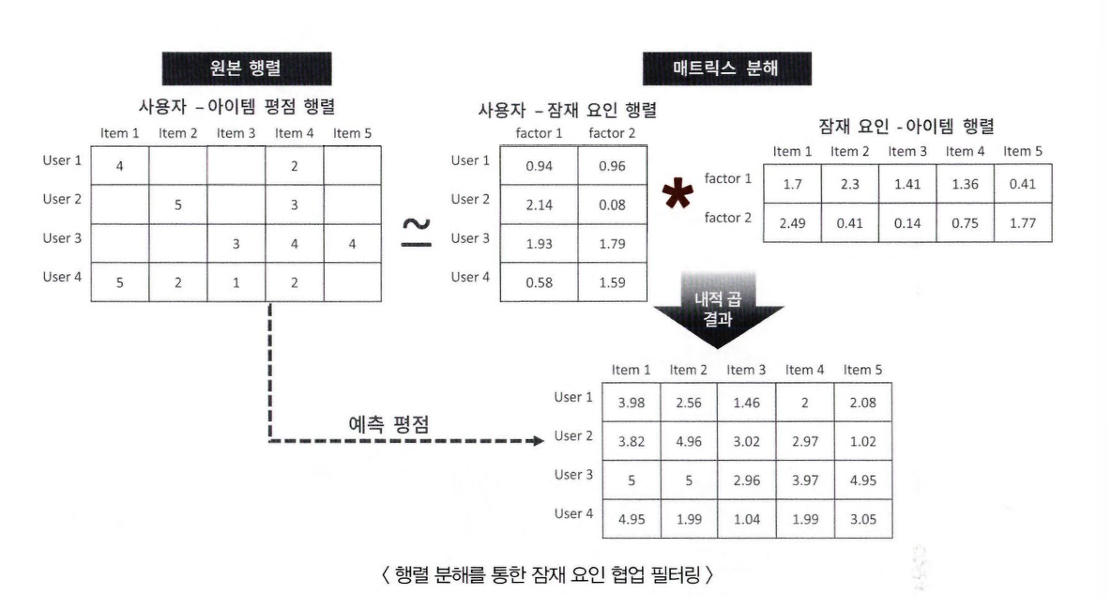


* 잠재요인을 정확히 명명할수는 X

* 잠재 요인을 기반으로 분해된 매트릭스를 이용해 예측 평가 수행.



> 행렬 분해의 이해

◾행렬 분해: 다차원 매트릭스를 저차원 매트릭스로 분해하는 기법. SVD, NMF 등

* R(M X N 차원의 사용자-아이템 평점 행렬)
  = P(M X K 차원의 사용자 - 잠재요인 행렬)* Q.T (N X K 차원의 아이템 - 잠재 요인 행렬의 전치 행렬)

* SVD - NaN 이 없는 행렬에만 적용 가능 (R 분해에 부적합)
 ➡ SGD, ALS 방식을 이용해 SVD 수행

> SGD를 이용한 행렬 분해: P,Q 행렬로 계산된 예측 R 행렬 값이 실제 R 행렬 값과 가장 최소의 오류를 가질 수 있도록 반복적인 비용 함수 최적화를 통해 P, Q 유추






















💻












# [코드 필사]

In [1]:
## SGD를 이용한 행렬 분해

import numpy as np

# 원본 행렬 R 생성, 분해 행렬 P,Q 초기화, 잠재 요인 차원 K=3으로 설정
R = np.array([[4, np.nan, np.nan, 2, np.nan],
              [np.nan, 5, np.nan, 3, 1],
              [np.nan, np.nan, 3, 4, 4],
              [5, 2, 1, 2, np.nan]])
num_users, num_items = R.shape
K = 3

# P,Q 행렬의 크기를 지정하고 정규 분포를 가진 임의의 값으로 입력
np.random.seed(1)
P = np.random.normal(scale=1./K, size=(num_users, K))
Q = np.random.normal(scale=1./K, size=(num_items, K))

In [2]:
from sklearn.metrics import mean_squared_error

def get_rmse(R, P, Q, non_zeros):
  error = 0
  # 두 개의 분해된 행렬 P, Q.T 내적으로 예측 R 행렬 생성
  full_pred_matrix = np.dot(P, Q.T)

  # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출해 실제 R 행렬과 예측 행렬의 RMSE 추출
  x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
  y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
  R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
  full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
  mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
  rmse = np.sqrt(mse)

  return rmse

In [3]:
# R>0인 행 위치, 열 위치, 값을 non_zeros 리스트에 저장
non_zeros = [(i, j, R[i, j]) for i in range(num_users) for j in range(num_items) if R[i, j] > 0]

steps = 1000 # SGD를 반복해서 업데이트할 횟수
learning_rate = 0.01 # SGD 학습률
r_lambda = 0.01 # L2 규제 계수

# SGD 기법으로 P,Q 계속 업데이트
for step in range(steps):
  for i, j, r in non_zeros:
    # 실제 값과 예측 값의 차이인 오류 값 구함
    eij = r - np.dot(P[i, :], Q[j, :].T)
    # Regularization을 반영한 SGD 업데이트 공식 적용
    P[i, :] = P[i, :] + learning_rate * (eij * Q[j, :] - r_lambda * P[i, :])
    Q[j, :] = Q[j, :] + learning_rate * (eij * P[i, :] - r_lambda * Q[j, :])

    rmse = get_rmse(R, P, Q, non_zeros)
  if (step % 50) == 0:
    print("### iteration step: ", step, " rmse: ", rmse)

### iteration step:  0  rmse:  3.2388050277987723
### iteration step:  50  rmse:  0.4876723101369648
### iteration step:  100  rmse:  0.1564340384819247
### iteration step:  150  rmse:  0.07455141311978046
### iteration step:  200  rmse:  0.04325226798579314
### iteration step:  250  rmse:  0.029248328780878973
### iteration step:  300  rmse:  0.022621116143829466
### iteration step:  350  rmse:  0.019493636196525135
### iteration step:  400  rmse:  0.018022719092132704
### iteration step:  450  rmse:  0.01731968595344266
### iteration step:  500  rmse:  0.016973657887570753
### iteration step:  550  rmse:  0.016796804595895633
### iteration step:  600  rmse:  0.01670132290188466
### iteration step:  650  rmse:  0.01664473691247669
### iteration step:  700  rmse:  0.016605910068210026
### iteration step:  750  rmse:  0.016574200475705
### iteration step:  800  rmse:  0.01654431582921597
### iteration step:  850  rmse:  0.01651375177473524
### iteration step:  900  rmse:  0.016481465738

In [4]:
# 분해된 P,Q 함수를 P * Q.T로 예측 행렬을 만들어 출력
pred_matrix = np.dot(P, Q.T)
print("예측 행렬: \n", np.round(pred_matrix, 3))

예측 행렬: 
 [[3.991 0.897 1.306 2.002 1.663]
 [6.696 4.978 0.979 2.981 1.003]
 [6.677 0.391 2.987 3.977 3.986]
 [4.968 2.005 1.006 2.017 1.14 ]]
